In [1]:
import csv
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from collections import defaultdict

## 1. Construct LSH Hash Tables

### A. Report the number of users (|U|) and the number of features (n)

In [2]:
users = {}
with open('bitvector_users.csv', 'r') as file:
    records = csv.reader(file, delimiter='\t')
    for record in records:
        user_id = int(record[0])
        bitvector = [int(bit) for bit in record[1:]]
        users[user_id] = bitvector

n_user = len(users)
n_feat = len(users[0])
print(f"Number of users = {n_user}")
print(f"Number of Features = {n_feat}")

Number of users = 2574
Number of Features = 7855


### B. Construct a family of MinHash functions in the LSH family
Construct a family of MinHash functions in the LSH family. You can choose a prime number, denoted as p, and coefficients 0 < a < p,0 ≤ b < p. Let the tunable hash size k, and report the family of MinHash functions you have generated with k ∈ {1, 2, 3, 4}, respectively.

In [3]:
 # Define a prime number p
p = 2147483647 # Mersenne prime number

# Function to generate MinHash functions
def Minhash(k, p, seed):
    minhash_functions = []
    if seed is not None:
        random.seed(seed)
    for _ in range(k):
        a = random.randint(1, p)
        b = random.randint(0, p-1)
        minhash_functions.append((a, b))
    return minhash_functions

# Generate MinHash functions for each k
minhash_families = {}
K = [1, 2, 3, 4]
seed = 99
for k in K:
    minhash_families[k] = Minhash(k, p, seed)

# Print the generated MinHash functions
for k, functions in minhash_families.items():
    print(f"MinHash functions for k = {k}:")
    for a, b in functions:
        print(f"h(x) = ({a}x + {b}) % {p}")
    print()

MinHash functions for k = 1:
h(x) = (867536309x + 817660058) % 2147483647

MinHash functions for k = 2:
h(x) = (867536309x + 817660058) % 2147483647
h(x) = (429658752x + 1287285677) % 2147483647

MinHash functions for k = 3:
h(x) = (867536309x + 817660058) % 2147483647
h(x) = (429658752x + 1287285677) % 2147483647
h(x) = (383975071x + 494485440) % 2147483647

MinHash functions for k = 4:
h(x) = (867536309x + 817660058) % 2147483647
h(x) = (429658752x + 1287285677) % 2147483647
h(x) = (383975071x + 494485440) % 2147483647
h(x) = (533502200x + 286140160) % 2147483647



### C. Construct one (L = 1) LSH hash table using MinHash functions
Construct one (L = 1) LSH hash table using MinHash functions with bucket size (m = 3000) with k = 2. Report all users collided with the user with ID = 2186 in the constructed hash table and their corresponding Jaccard similarity.

In [5]:
k = 2
seed = 42
p = 2147483647 # Mersenne prime number
users = pd.DataFrame(users)
minhash_functions = Minhash(k, p, seed)

def Minhash_sign(v, minhash_functions, p, n):
    signature = []
    for a, b in minhash_functions:
        minhash_value = float('inf')
        for key, val in v.items():
            if val == 1:
                hash_value = ((a * key + b) % p) % n
                if hash_value < minhash_value:
                    minhash_value = hash_value
        signature.append(minhash_value)
    return tuple(signature)

# Create LSH hash table
m = 3000
user_target = 2186
lsh_table = defaultdict(list)

for user in users.keys():
    signature = Minhash_sign(users[user], minhash_functions, p, n_feat)
    bucket = (hash(signature) % p) % m
    lsh_table[bucket].append(user)
    if user == user_target:
        buck_target = bucket

collided_users = lsh_table[buck_target]

# Function to compute Jaccard similarity
def jac_sim(v1, v2):
    intersection = sum([a == 1 and b == 1 for a, b in zip(v1, v2)])
    union = sum([a == 1 or b == 1 for a, b in zip(v1, v2)])
    return intersection / union if union != 0 else 0

# Report collided users and their Jaccard similarity
print(f"Users collided with user {user_target}:")
for user_id in collided_users:
    if user_id != user_target:
        similarity = jac_sim(users[user_target], users[user_id])
        print(f"User ID: {user_id}, Jaccard Similarity: {similarity:.4f}")


Users collided with user 2186:
User ID: 271, Jaccard Similarity: 0.0929
User ID: 286, Jaccard Similarity: 0.0805
User ID: 560, Jaccard Similarity: 0.1049
User ID: 1283, Jaccard Similarity: 0.0633
User ID: 1477, Jaccard Similarity: 0.0551
User ID: 1701, Jaccard Similarity: 0.0119
User ID: 2324, Jaccard Similarity: 0.7374


### D. Construct L = 10 LSH hash tables using MinHash functions with bucket size (m = 3000) and k = 2.

In [6]:
k = 2
seed = 604
p = 100003
#p = 2147483647 # Mersenne prime number
users = pd.DataFrame(users)
minhash_functions = Minhash(k, p, seed)


def Minhash_sign(v, minhash_functions, p, n):
    signature = []
    for a, b in minhash_functions:
        minhash_value = float('inf')
        for key, val in v.items():
            if val == 1:
                hash_value = ((a * key + b) % p) % n
                if hash_value < minhash_value:
                    minhash_value = hash_value
        signature.append(minhash_value)
    return tuple(signature)

m = 3000
bands = 10
# user in Q
Q = [2186]
# initialize lsh table
all_lsh_tables = {}
buck_target = {}
buck_contain = {}
collided_users = defaultdict(set)

for b in range(bands):
    # Create LSH hash table
    lsh_table = defaultdict(list)
    for user in users.keys():
        signature = Minhash_sign(users[user], minhash_functions, p, n_feat)
        bucket = (hash(signature) % p) % m
        lsh_table[bucket].append(user)
    all_lsh_tables[b] = lsh_table

for b in all_lsh_tables:
    for user_target in Q:
        sign_target = Minhash_sign(users[user_target], minhash_functions, p, n_feat)
        buck_target = (hash(sign_target) % p) % m
        buck_contain = lsh_table[buck_target]
        collided_users[user_target].update(buck_contain)

# Function to compute Jaccard similarity
def jac_sim(v1, v2):
    intersection = sum([a == 1 and b == 1 for a, b in zip(v1, v2)])
    union = sum([a == 1 or b == 1 for a, b in zip(v1, v2)])
    return intersection / union if union != 0 else 0

for user_q in collided_users:
     print(f"Users collided with user {user_q}:")
     for user in collided_users[user_q]:
          if user != user_q:
              similarity = jac_sim(users[user_q], users[user])
              print(f"User ID: {user}, Jaccard Similarity: {similarity:.4f}")   

Users collided with user 2186:
User ID: 1488, Jaccard Similarity: 0.0601
User ID: 148, Jaccard Similarity: 0.0071
User ID: 2324, Jaccard Similarity: 0.7374
User ID: 1302, Jaccard Similarity: 0.0201
User ID: 2295, Jaccard Similarity: 0.0274
User ID: 2488, Jaccard Similarity: 0.0676


## 2. Nearest Neighbor Search

### A. Report the top-5 users with the highest Jaccard similarities as the answer for user Q = {295, 1053, 1080, 2186}

In [7]:
Q = [295, 1053, 1080, 2186]
buck_target = {}
buck_contain = {}
collided_users = defaultdict(set)

for b in all_lsh_tables:
    for user_target in Q:
        sign_target = Minhash_sign(users[user_target], minhash_functions, p, n_feat)
        buck_target = (hash(sign_target) % p) % m
        buck_contain = all_lsh_tables[b][buck_target]
        collided_users[user_target].update(buck_contain)

# Estimate Top-5 jaccard simmilarity
for user_q in collided_users:
    candidates = collided_users[user_q].copy()
    candidates.discard(user_q)
    similarities = []
    for user in candidates:
        sim = jac_sim(users[user_q], users[user])
        similarities.append((user, sim))
    
    # Sort 
    top_k = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]
    
    print(f"Query: {user_q}, Top-5:[", end='')
    print(', '.join([f"({u}, {sim:.4f})" for u, sim in top_k]), end='')
    print("]")

Query: 295, Top-5:[(793, 0.1339), (1648, 0.1277), (1043, 0.0979), (646, 0.0645), (2377, 0.0609)]
Query: 1053, Top-5:[(707, 0.0279), (108, 0.0261), (798, 0.0260), (1590, 0.0245), (2430, 0.0223)]
Query: 1080, Top-5:[(2523, 0.1124), (1078, 0.0775), (2120, 0.0635), (231, 0.0617), (413, 0.0578)]
Query: 2186, Top-5:[(2324, 0.7374), (2488, 0.0676), (1488, 0.0601), (2295, 0.0274), (1302, 0.0201)]


### B. Compute the true top-5 similar users from the dataset for user Q = {295, 1053, 1080, 2186}

In [66]:
Q = [295, 1053, 1080, 2186]
similarities = []
for user_q in Q:
    for user in users.keys():
        if user_q != user:
            sim = jac_sim(users[user_q], users[user])
            similarities.append((user, sim))
    
    # Sort 
    top_k = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]
    
    print(f"Query: {user_q}, Top-5:[", end='')
    print(', '.join([f"({u}, {sim:.4f})" for u, sim in top_k]), end='')
    print("]")

Query: 295, Top-5:[(374, 0.4274), (2246, 0.2086), (1223, 0.1986), (2421, 0.1634), (730, 0.1627)]
Query: 1053, Top-5:[(374, 0.4274), (1345, 0.3165), (2246, 0.2086), (1223, 0.1986), (2421, 0.1634)]
Query: 1080, Top-5:[(2225, 0.5319), (374, 0.4274), (1345, 0.3165), (2246, 0.2086), (1223, 0.1986)]
Query: 2186, Top-5:[(2324, 0.7374), (2225, 0.5319), (374, 0.4274), (1345, 0.3165), (2246, 0.2086)]


## 3. Search Quality and Efficiency

### A. Investigate the impact of the hash size k ∈ {1,2,3,4} on the quality of the top-k nearest neighbor search

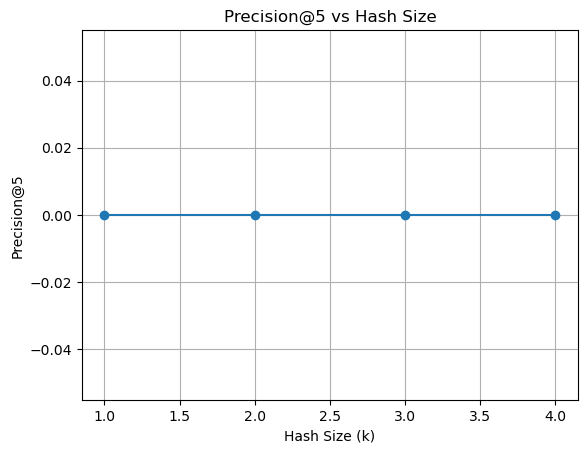

In [8]:
p = 100003
m = 3000
seed = 604
bands = 10

cand_k = [1, 2, 3, 4]
precisions = []
for k in cand_k:
    minhash_functions = Minhash(k, p, seed)
    all_lsh_tables = {}

    for b in range(bands):
        # Create LSH hash table
        lsh_table = defaultdict(list)
        for user in users.keys():
            signature = Minhash_sign(users[user], minhash_functions, p, n_feat)
            bucket = (hash(signature) % p) % m
            lsh_table[bucket].append(user)
        all_lsh_tables[b] = lsh_table

    Q = range(1001, 2000)
    buck_target = {}
    buck_contain = {}
    collided_users = defaultdict(set)
    gt = defaultdict(list)
    pred = defaultdict(list)

    for b in all_lsh_tables:
        for user_target in Q:
            sign_target = Minhash_sign(users[user_target], minhash_functions, p, n_feat)
            buck_target = (hash(sign_target) % p) % m
            buck_contain = all_lsh_tables[b][buck_target]
            collided_users[user_target].update(buck_contain)

    precision_sum = 0
    # Estimate Top-5 jaccard simmilarity
    for user_q in collided_users:
        candidates = collided_users[user_q].copy()
        candidates.discard(user_q)
        sim_truth = []
        sim_pred = []
        # estimate similarities
        for user in users.keys():
            if user_target != user:
                sim = jac_sim(users[user_q], users[user])
                sim_truth.append((user, sim))
                if user in candidates:
                    sim_pred.append((user, sim))
        gt[user_q] = sorted(sim_truth, key=lambda x: x[1], reverse=True)[:5]
        pred[user_q] = sorted(sim_pred, key=lambda x: x[1], reverse=True)[:5]
        gt[user_q] = (x for x, y in gt[user_q])
        pred[user_q] = (x for x, y in gt[user_q])

        # Calculate Precision@5
        R_q = set(gt[user_q])
        R_hat_q = set(pred[user_q])
        if len(R_hat_q) > 0:
            precision_sum += len(R_q & R_hat_q) / len(R_hat_q)

    precision_at_5 = precision_sum / len(Q)
    precisions.append(precision_at_5)

# Plotting the results
plot.plot(cand_k, precisions, marker='o')
plot.xlabel('Hash Size (k)')
plot.ylabel('Precision@5')
plot.title('Precision@5 vs Hash Size')
plot.grid(True)
plot.show()



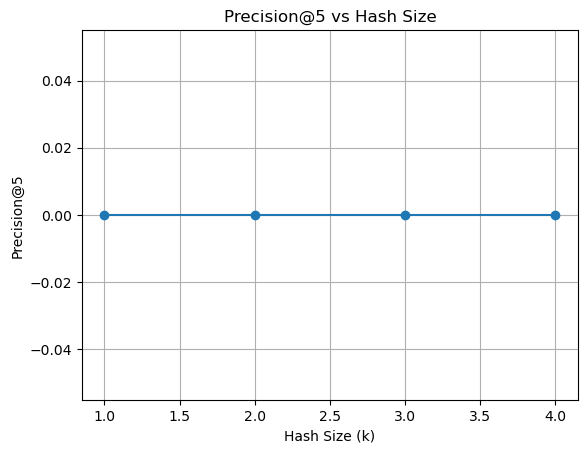

In [72]:

def get_ground_truth(users, user_target):
    sim_truth = []
    # estimate similarities
    for user in users.keys():
            if user_target != user:
                sim = jac_sim(users[user_target], users[user])
                sim_truth.append((user, sim))
    gt = sorted(sim_truth, key=lambda x: x[1], reverse=True)[:5]
    return gt  

p = 100003
m = 3000
seed = 604
bands = 10

cand_k = [1, 2, 3, 4]
precisions = []

for k in cand_k:
    minhash_functions = Minhash(k, p, seed)
    all_lsh_tables = {}

    for b in range(bands):
        # Create LSH hash table
        lsh_table = defaultdict(list)
        for user in users.keys():
            signature = Minhash_sign(users[user], minhash_functions, p, n_feat)
            bucket = (hash(signature) % p) % m
            lsh_table[bucket].append(user)
        all_lsh_tables[b] = lsh_table

    Q = range(1001, 2000)
    collided_users = defaultdict(set)
    ground_truth = defaultdict(list)
    pred = defaultdict(list)

    for b in all_lsh_tables:
        for user_target in Q:
            sign_target = Minhash_sign(users[user_target], minhash_functions, p, n_feat)
            buck_target = (hash(sign_target) % p) % m
            buck_contain = all_lsh_tables[b][buck_target]
            collided_users[user_target].update(buck_contain)

    # Estimate Top-5 Jaccard similarity
    for user_q in collided_users:
        candidates = collided_users[user_q].copy()
        candidates.discard(user_q)
        sim_pred = []

        for candidate in candidates:
            sim = jac_sim(users[user_q], users[candidate])
            sim_pred.append((candidate, sim))

        # Sort candidates by similarity and take top-5
        sim_pred.sort(key=lambda x: x, reverse=True)
        pred[user_q] = [x for x in sim_pred[:5]]

    # Calculate Precision@5
    precision_sum = 0
    for user_q in Q:
        R_q = set(ground_truth[user_q])
        R_hat_q = set(pred[user_q])
        if len(R_hat_q) > 0:
            precision_sum += len(R_q & R_hat_q) / len(R_hat_q)

    precision_at_5 = precision_sum / len(Q)
    precisions.append(precision_at_5)

# Plotting the results
plot.plot(cand_k, precisions, marker='o')
plot.xlabel('Hash Size (k)')
plot.ylabel('Precision@5')
plot.title('Precision@5 vs Hash Size')
plot.grid(True)
plot.show()


### B. Compare the query time in Question 2(a) and Question 2(b) on average across the query set Q in milliseconds and comment on their differences

In [77]:
Q = range(1001, 2000)
buck_target = {}
buck_contain = {}
collided_users = defaultdict(set)
elaps_2a = []
elaps_2b = []

for b in range(bands):
    # Create LSH hash table
    lsh_table = defaultdict(list)
    for user in users.keys():
        signature = Minhash_sign(users[user], minhash_functions, p, n_feat)
        bucket = (hash(signature) % p) % m
        lsh_table[bucket].append(user)
    all_lsh_tables[b] = lsh_table

for b in all_lsh_tables:
    
    for user_target in Q:
        sign_target = Minhash_sign(users[user_target], minhash_functions, p, n_feat)
        buck_target = (hash(sign_target) % p) % m
        buck_contain = all_lsh_tables[b][buck_target]
        collided_users[user_target].update(buck_contain)

# Estimate Top-5 jaccard simmilarity
for user_q in collided_users:
    start1 = time.time()
    candidates = collided_users[user_q].copy()
    candidates.discard(user_q)
    similarities = []
    for user in candidates:
        sim = jac_sim(users[user_q], users[user])
        similarities.append((user, sim))
    
    # Sort 
    top_k = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]
    
    end1 = time.time()
    elap1 = (end1 - start1)*1000
    elaps_2a.apppend(elap1)

similarities = []
for user_q in Q:
    start2 = time.time()
    for user in users.keys():
        if user_q != user:
            sim = jac_sim(users[user_q], users[user])
            similarities.append((user, sim))
    
    # Sort 
    top_k = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]
    end2 =time.time()
    elap2 = (end2 - start2)*1000
    elaps_2b.apppend(elap2)

def average(arr):
    if len(arr) == 0:
        return 0
    return sum(arr) / len(arr)
print(f"Average for 2a is = {average(elaps_2a)}")
print(f"Average for 2b is = {average(elaps_2b)}")

AttributeError: 'list' object has no attribute 'apppend'